The spelled-out intro to neural networks and backpropagation: building micrograd

https://www.youtube.com/watch?v=VMj-3S1tku0

In [8]:
from __future__ import annotations

import math
import random

import numpy as np
import matplotlib.pyplot as plt
import torch

In [5]:
class Value:
     def __init__(self, data, _children=(), _op='', label='') -> None:
          self.data = data
          self.grad = 0.0
          self._backward = lambda: None
          self._prev = set(_children)
          self._op = _op
          self.label = label

     def __repr__(self) -> str:
          return f"Value(data={self.data})"

     def __add__(self, other: Value) -> Value:
          other = other if isinstance(other, Value) else Value(other)
          out = Value(self.data + other.data, (self, other), "+")
          def _backward():
               self.grad += 1.0 * out.grad
               other.grad += 1.0 * out.grad
          out._backward = _backward
          return out
     
     def __radd__(self, other):
          return self + other
     
     def __sub__(self, other: Value) -> Value:
          return self + -1*other
     
     def __rsub__(self, other):
          return -1*self + other
     
     def __mul__(self, other: Value) -> Value:
          other = other if isinstance(other, Value) else Value(other)
          out = Value(self.data * other.data, (self, other), "*")
          def _backward():
               self.grad += other.data * out.grad
               other.grad += self.data * out.grad
          out._backward = _backward
          return out 
     
     def __rmul__(self, other) -> Value:
          return self * other
     
     def __pow__(self, other):
          assert isinstance(other, (int, float))
          out = Value(self.data**other, (self, ), f"**{other}")
          def _backward():
               self.grad += other * self.data**(other - 1) * out.grad
          out._backward = _backward
          return out
     
     def __truediv__(self, other):
          return self * other**-1
     
     def __rtruediv__(self, other):
          return self**-1 * other
     
     def tanh(self) -> Value:
          x = self.data
          t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
          out = Value(t, (self, ), "tanh")
          def _backward():
               self.grad += (1 - t**2) * out.grad
          out._backward = _backward
          return out
     
     def exp(self):
          x = self.data
          out = Value(math.exp(x), (self, ), 'exp')
          def _backward():
               self.grad += out.data * out.grad
          out._backward = _backward
          return out
     
     def backward(self):
          topo = []
          visited = set()
          def build_topo(v):
               if v not in visited:
                    visited.add(v)
                    for child in v._prev:
                         build_topo(child)
                    topo.append(v)
          build_topo(self)

          self.grad = 1.0
          for node in reversed(topo):
               node._backward()
     

In [2]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [19]:
from graphviz import Digraph

def trace(root: Value):
    nodes, edges = set(), set()
    def build(v: Value):
        nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)
    build(root)
    return nodes, edges

def draw_dot(root: Value):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [40]:
from typing import Any


class Neuron:
    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w*x+b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def paramaters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts: list) -> None:
        sizes = [nin] + nouts
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.paramaters()]


In [41]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
r = n(x)
r

Value(data=0.9447360185667703)

In [42]:
n.parameters()

[Value(data=-0.11750953528948593),
 Value(data=0.1494589700663007),
 Value(data=0.8737241676741507),
 Value(data=-0.3163844823627069),
 Value(data=-0.2087551304853077),
 Value(data=0.4299334148818117),
 Value(data=0.6817982875543014),
 Value(data=-0.7936818400737864),
 Value(data=-0.5137975937545955),
 Value(data=-0.21550127075633396),
 Value(data=0.5884086740478947),
 Value(data=-0.03757747382225873),
 Value(data=-0.3063446910462977),
 Value(data=-0.570183499747374),
 Value(data=-0.15429396304222154),
 Value(data=0.7317884190011141),
 Value(data=0.009883852524276593),
 Value(data=-0.8225661089187752),
 Value(data=-0.23198087041830373),
 Value(data=0.734234660391913),
 Value(data=0.40006412985975404),
 Value(data=-0.8551387220100695),
 Value(data=0.8412461803887235),
 Value(data=0.3117163774499878),
 Value(data=0.5964376550539501),
 Value(data=-0.13992617208163094),
 Value(data=0.07496075795526846),
 Value(data=0.6150294641695815),
 Value(data=-0.37446902283615646),
 Value(data=0.40907

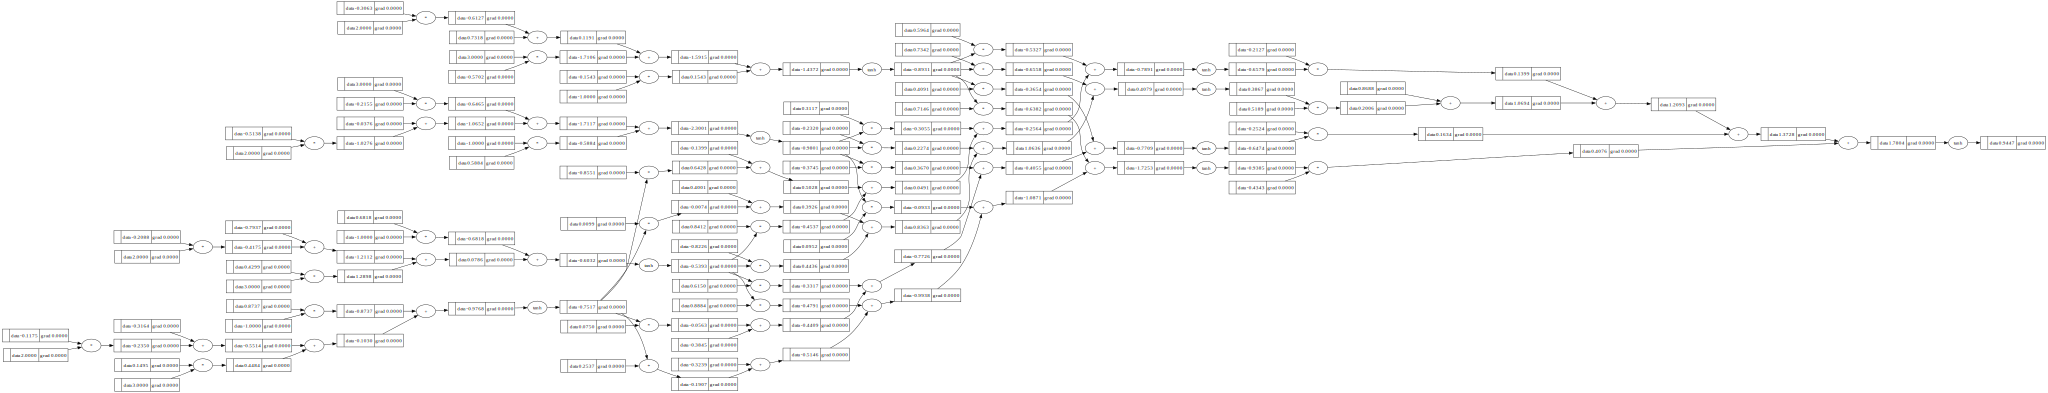

In [43]:
draw_dot(r)

In [44]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [45]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9447360185667703),
 Value(data=0.9593425507769895),
 Value(data=0.8133985251403035),
 Value(data=0.9582033166472643)]

In [46]:
# Mean squared error loss
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.132238512649448)

In [50]:
loss.backward()

In [51]:
n.layers[0].neurons[0].w[0].data, n.layers[0].neurons[0].w[0].grad

(-0.11750953528948593, 0.061592264444075465)

In [52]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [86]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

In [ ]:
for i in range(2000):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # forward pass
    for p in n.parameters():
        p.grad = 0
    loss.backward()
    for p in n.parameters():
        p.data += -0.003 * p.grad
    if i % 30 == 0:
        print(f"Step: {i}, loss: {loss}")

In [89]:
loss, ypred

(Value(data=0.008481785990957915),
 [Value(data=0.9563051249616673),
  Value(data=-0.9602623967661871),
  Value(data=-0.9516482032092519),
  Value(data=0.948467771999644)])